In [92]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: ucimlrepo in c:\users\8983\appdata\local\programs\python\python310\lib\site-packages (0.0.7)



You should consider upgrading via the 'c:\Users\8983\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo

In [94]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("schmoyote/coffee-reviews-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\8983\.cache\kagglehub\datasets\schmoyote\coffee-reviews-dataset\versions\6


In [95]:
df = pd.read_csv(r"C:\Users\8983\.cache\kagglehub\datasets\schmoyote\coffee-reviews-dataset\versions\6/coffee_analysis.csv")
df.head()

,name,roaster,roast,loc_country,origin_1,origin_2,100g_USD,rating,review_date,desc_1,desc_2,desc_3
0,“Sweety” Espresso Blend,A.R.C.,Medium-Light,Hong Kong,Panama,Ethiopia,14.32,95,November 2017,"Evaluated as espresso. Sweet-toned, deeply ric...",An espresso blend comprised of coffees from Pa...,A radiant espresso blend that shines equally i...
1,Flora Blend Espresso,A.R.C.,Medium-Light,Hong Kong,Africa,Asia Pacific,9.05,94,November 2017,"Evaluated as espresso. Sweetly tart, floral-to...",An espresso blend comprised of coffees from Af...,"A floral-driven straight shot, amplified with ..."
2,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,Guji Zone,Southern Ethiopia,4.70,92,November 2017,"Crisply sweet, cocoa-toned. Lemon blossom, roa...",This coffee tied for the third-highest rating ...,"A gently spice-toned, floral- driven wet-proce..."
3,Ethiopia Suke Quto,Roast House,Medium-Light,United States,Guji Zone,Oromia Region,4.19,92,November 2017,"Delicate, sweetly spice-toned. Pink peppercorn...",This coffee tied for the third-highest rating ...,Lavender-like flowers and hints of zesty pink ...
4,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Gedeb District,Gedeo Zone,4.85,94,November 2017,"Deeply sweet, subtly pungent. Honey, pear, tan...",Southern Ethiopia coffees like this one are pr...,A deeply and generously lush cup saved from se...


# EDA

In [96]:
df.describe()

,100g_USD,rating
count,2095.000000,2095.000000
mean,9.323313,93.114081
std,11.430659,1.563024
min,0.120000,84.000000
25%,4.930000,92.000000
50%,5.860000,93.000000
75%,8.785000,94.000000
max,132.280000,98.000000


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2095 non-null   object 
 1   roaster      2095 non-null   object 
 2   roast        2080 non-null   object 
 3   loc_country  2095 non-null   object 
 4   origin_1     2095 non-null   object 
 5   origin_2     2095 non-null   object 
 6   100g_USD     2095 non-null   float64
 7   rating       2095 non-null   int64  
 8   review_date  2095 non-null   object 
 9   desc_1       2095 non-null   object 
 10  desc_2       2095 non-null   object 
 11  desc_3       2093 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 196.5+ KB


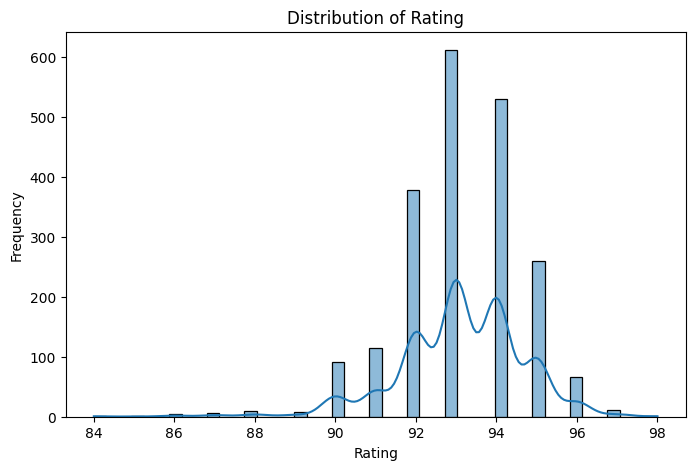

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

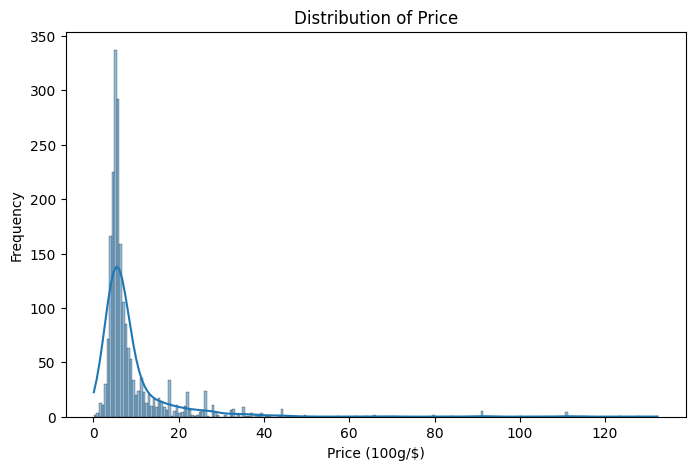

In [99]:
plt.figure(figsize=(8, 5))
sns.histplot(df['100g_USD'], kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price (100g/$)')
plt.ylabel('Frequency')
plt.show()

In [100]:
#checking for missing values
df.isnull().sum()

name            0
roaster         0
roast          15
loc_country     0
origin_1        0
origin_2        0
100g_USD        0
rating          0
review_date     0
desc_1          0
desc_2          0
desc_3          2
dtype: int64

In [101]:
df["desc_3"] = df["desc_3"].fillna("")

In [102]:
cat_cols = ["roast", "loc_country"]
num_cols = ["100g_USD"]
df["text"] = df["desc_1"] + " " + df["desc_2"] + " " + df["desc_3"]
text_col = "text"

In [103]:
unique_values = {}
for col in cat_cols:
    unique_values[col] = df[col].unique()
    print(f"Unique values in {col}: {unique_values[col]}")

Unique values in roast: ['Medium-Light' 'Medium' 'Light' 'Medium-Dark' nan 'Dark']
Unique values in loc_country: ['Hong Kong' 'United States' 'Canada' 'Taiwan' "Hawai'i" 'Australia'
 'England' 'Uganda' 'Mexico' 'Belgium' 'United States And Floyd'
 'Guatemala' 'Japan' 'Peru' 'Honduras' 'China' 'Kenya' 'Malaysia'
 'New Taiwan']


# Supervised ML

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor

from scipy.sparse import hstack, csr_matrix

y = df["rating"]
X = df[[text_col] + num_cols + cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42
)

X_train_cat = pd.get_dummies(X_train[cat_cols], drop_first=False, dtype=int)
X_test_cat  = pd.get_dummies(X_test[cat_cols], drop_first=False, dtype=int)

# Align columns
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Standardize
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

X_train_num = csr_matrix(X_train_num)
X_test_num  = csr_matrix(X_test_num)

# TF-IDF
# Handle NaN values in the text column by filling them with empty strings
X_train[text_col] = X_train[text_col].fillna("").astype(str)
X_test[text_col] = X_test[text_col].fillna("").astype(str)

tfidf = TfidfVectorizer(max_features=3000, stop_words="english")
X_train_text = tfidf.fit_transform(X_train[text_col])
X_test_text  = tfidf.transform(X_test[text_col])

# splice all data
X_train_all = hstack([X_train_text, csr_matrix(X_train_cat), X_train_num])
X_test_all  = hstack([X_test_text, csr_matrix(X_test_cat), X_test_num])

In [105]:
rf_cat_cols = X_train_cat.columns.tolist()

import joblib
joblib.dump(rf_cat_cols, "models/rf_cat_cols.pkl")

['models/rf_cat_cols.pkl']

# 1. Linear Regression

In [106]:
# Training the model
lr_model = LinearRegression()
lr_model.fit(X_train_all, y_train)

# Making predictions
y_pred = lr_model.predict(X_test_all)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 3.3891825718729165
R2 Score: -0.40769057144481713


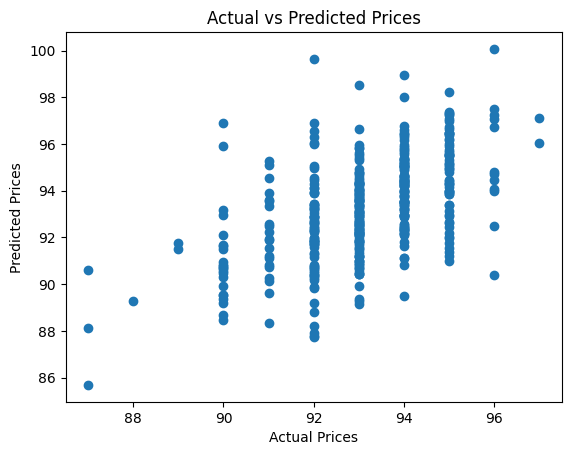

In [107]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

The R2 score is low, fit badly.

# 2. RandomForest

In [108]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_all, y_train)

# Making predictions
y_pred = rf_model.predict(X_test_all)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.9597355608591887
R2 Score: 0.6013756498944838


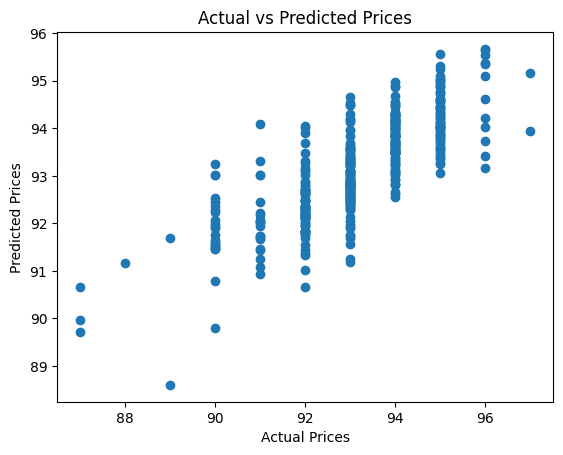

In [109]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

In [110]:
joblib.dump(scaler, "models/rf_price_scaler.pkl")

joblib.dump(tfidf, "tfidf.pkl")

joblib.dump(rf_model, "rf_rating.pkl")

['rf_rating.pkl']

Fit fairly good from the R2 score

# Unsupervised

In [111]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from ucimlrepo import fetch_ucirepo

In [112]:
cat_cols2 = ["loc_country", "roast"]
num_cols2 = ["100g_USD", "rating"]
df_cat = pd.get_dummies(df[cat_cols2], dtype=int)
scaler = StandardScaler()
df_num = scaler.fit_transform(df[num_cols2])

df["text"] = df["text"].fillna("")
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

emb_text = model.encode(
    df["text"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)
# Combine all features
X_all = np.hstack([
    emb_text,
    df_cat.values,
    df_num
])

print("Final feature shape:", X_all.shape)

Batches: 100%|██████████| 66/66 [00:44<00:00,  1.49it/s]

Final feature shape: (2095, 410)


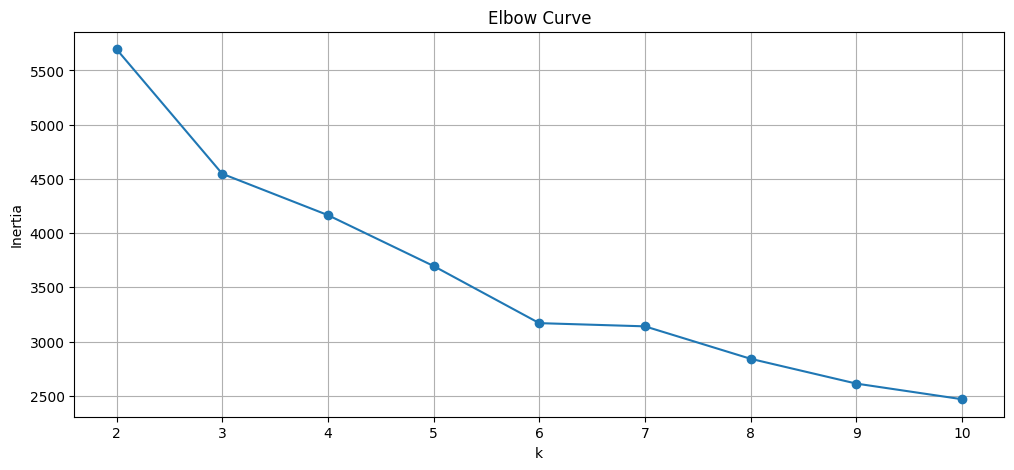

In [113]:
X = X_all

inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# Plot Elbow
plt.figure(figsize=(12,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

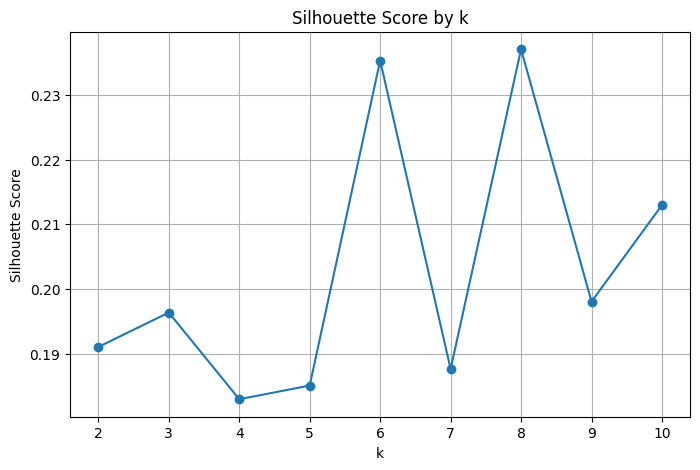

In [114]:
plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score by k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# PCA

In [115]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_data = pca.fit_transform(X_all)
np.save("models/pca_data.npy", pca_data)
joblib.dump(pca, "models/pca_2d.pkl")

['models/pca_2d.pkl']

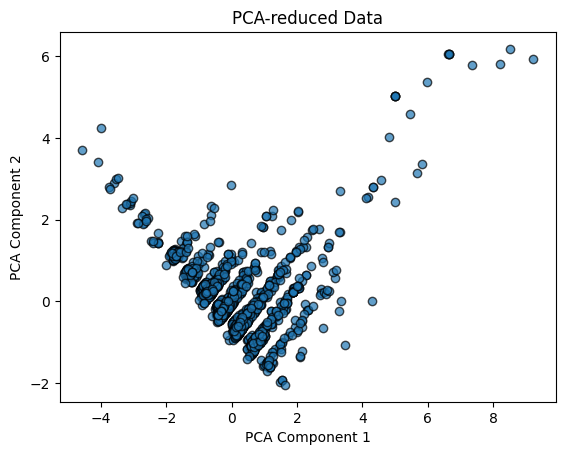

In [116]:
# Visualize PCA-reduced data
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.7, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA-reduced Data')
plt.show()

In [117]:
# Determine optimal number of clusters using Elbow Method
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

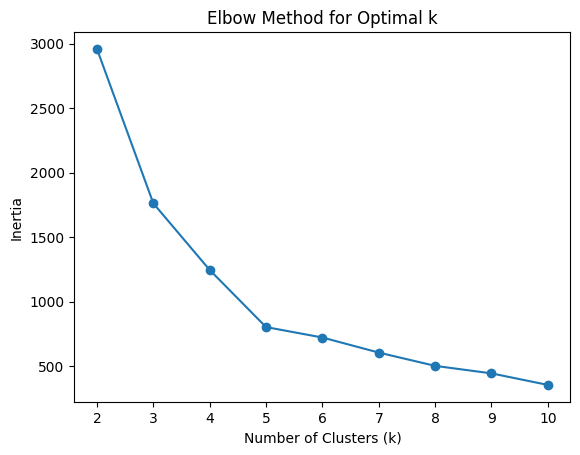

In [118]:
# Plot Elbow Method
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

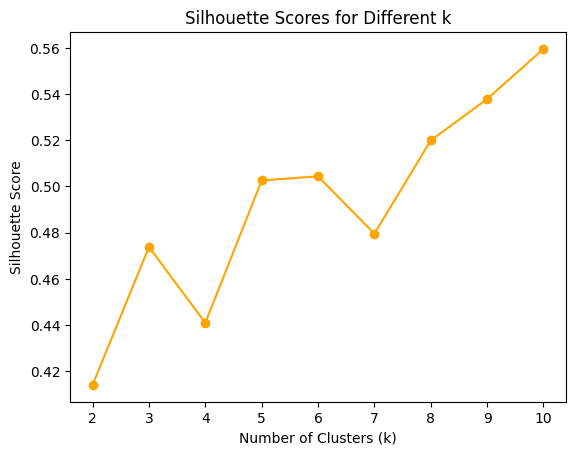

In [119]:
# Plot Silhouette Scores
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()

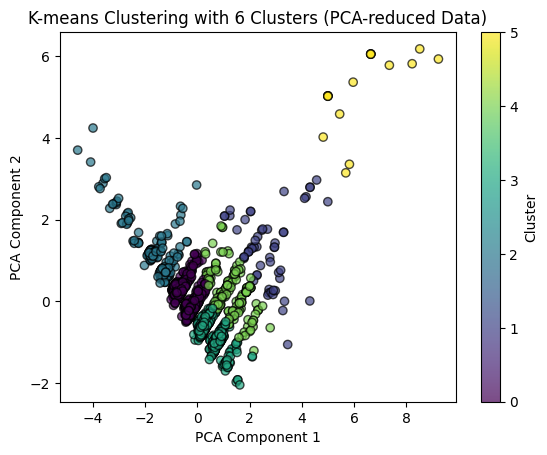

In [120]:
optimal_k = 6
kmeans = KMeans(n_clusters=6)
kmeans.fit(pca_data)

# Add cluster labels to the original dataset
df['Cluster'] = kmeans.labels_

# Visualize the clustered PCA-reduced data
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7, edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-means Clustering with {optimal_k} Clusters (PCA-reduced Data)')
plt.colorbar(label='Cluster')
plt.show()

The Silhouette Scores of the PCA is high, showing good performance, we can clearly see several distinct groups.

In [129]:
# 假设你已经有 df, pca_data, cluster_labels
df_plot = pd.DataFrame({
    "PC1": pca_data[:, 0],
    "PC2": pca_data[:, 1],
    "Cluster": cluster_labels,
    "Roast": df["roast"],
    "Origin": df["loc_country"],
    "Price": df["100g_USD"],
    "Rating": df["rating"],
    "Roaster": df["roaster"],
    "Name": df["name"]      # 方便以后用，顺便存一下
})

# 保存成一个文件（关键！）
df_plot.to_csv("models/pca_plot_data.csv", index=False)


NameError: name 'cluster_labels' is not defined

In [123]:
np.save("models/cluster_labels.npy", labels)
df.to_csv("data/df_for_pca.csv", index=False)


In [121]:
joblib.dump(pca_data, "models/pca_data.pkl")
joblib.dump(pca, "models/pca_model.pkl")
joblib.dump(labels, "models/cluster_labels.pkl")

['models/cluster_labels.pkl']

In [122]:
# Top key words of the clusters
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2),
)
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_all)

tfidf_matrix = vectorizer.fit_transform(df["text"])
feature_names = vectorizer.get_feature_names_out()
labels = kmeans.predict(X_all)
df["Cluster"] = labels

# explain every clusters
def top_keywords(cluster_id, top_n=20):
    idx = np.where(labels == cluster_id)[0]
    cluster_tfidf = tfidf_matrix[idx].mean(axis=0).A1
    top_idx = cluster_tfidf.argsort()[::-1][:top_n]
    return feature_names[top_idx]

# Key num_data of clusters
num_cols = ["100g_USD", "rating"]

def numeric_profile(cluster_id):
    return df[df.Cluster == cluster_id][num_cols].mean()

# Key categories of clusters
cat_cols = ["roaster", "roast", "loc_country", "origin_1", "origin_2"]

def categorical_top(cluster_id, top_n=5):
    res = {}
    subset = df[df.Cluster == cluster_id]

    for col in cat_cols:
        res[col] = subset[col].value_counts().head(top_n)
    return res

for c in sorted(df.Cluster.unique()):
    print("\n===============================")
    print(f" 📌Cluster {c}")
    print("===============================")

    print("\n Top Keywords:")
    print(top_keywords(c, 10))

    print("\n Numeric Features (mean):")
    print(numeric_profile(c))

    print("\n Categorical Features (top values):")
    cat = categorical_top(c)
    for col, vals in cat.items():
        print(f"\n  - {col}:")
        print(vals)
print(df["Cluster"].value_counts().sort_index())


 📌Cluster 0

 Top Keywords:
['coffee' 'sweet' 'chocolate' 'coffees' 'fruit' 'cup' 'toned' 'processed'
 'cocoa' 'notes']

 Numeric Features (mean):
100g_USD     5.997055
rating      92.478261
dtype: float64

 Categorical Features (top values):

  - roaster:
roaster
JBC Coffee Roasters         69
Paradise Roasters           38
Temple Coffee Roasters      32
RamsHead Coffee Roasters    24
Jackrabbit Java             18
Name: count, dtype: int64

  - roast:
roast
Medium-Light    580
Medium           71
Light            56
Medium-Dark       5
Name: count, dtype: int64

  - loc_country:
loc_country
United States    685
Canada             9
Hawai'i            8
Guatemala          4
Hong Kong          3
Name: count, dtype: int64

  - origin_1:
origin_1
Yirgacheffe Growing Region    39
Guji Zone                     27
Ethiopia                      15
Brazil                        12
Antigua Growing Region        11
Name: count, dtype: int64

  - origin_2:
origin_2
Guatemala            55
Colom

In [124]:
import joblib

In [125]:
# SAVE THE MODELS
joblib.dump(kmeans, "kmeans.pkl")

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [128]:
df.iloc[0]["name"]


'“Sweety” Espresso Blend'

In [126]:
import numpy as np
import json

k = kmeans.n_clusters   

cluster_keywords = {}

for c in range(k):
    top = top_keywords(c, top_n=15)
    cluster_keywords[c] = top.tolist()

with open("cluster_keywords.json", "w") as f:
    json.dump(cluster_keywords, f, indent=4)

cluster_keywords


{0: ['coffee',
  'sweet',
  'chocolate',
  'coffees',
  'fruit',
  'cup',
  'toned',
  'processed',
  'cocoa',
  'notes',
  'washed',
  'cedar',
  'visit www',
  'acidity',
  'produced'],
 1: ['coffee',
  'email',
  'fruit',
  'taiwan',
  'chocolate',
  'sweet',
  'toned',
  'cup',
  'espresso',
  'ethiopia',
  'notes',
  'processed',
  'tw',
  'cocoa',
  'coffees'],
 2: ['coffee',
  'fruit',
  'coffees',
  'cup',
  'sweet',
  'toned',
  'cocoa',
  'processed',
  'juicy',
  'tart',
  'arabica',
  'chocolate',
  'notes',
  'natural',
  'variety'],
 3: ['nespresso',
  'geisha',
  'coffee',
  'civet',
  'capsule',
  'compatible',
  'luwak',
  'cat',
  'civet cat',
  'gesha',
  'celebrated',
  'world',
  'fruit',
  'presented',
  'world celebrated'],
 4: ['coffee',
  'sweet',
  'chocolate',
  'nut',
  'toned',
  'cup',
  'gently',
  'coffees',
  'cocoa',
  'wood',
  'notes',
  'cedar',
  'blend',
  'fir',
  'roasted'],
 5: ['espresso',
  'chocolate',
  'coffee',
  'fruit',
  'email',
  'ta

In [127]:
joblib.dump(df_cat.columns.tolist(), "models/kmeans_ohe_cols.pkl")

['models/kmeans_ohe_cols.pkl']